In [46]:
import numpy as np
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
from sklearn import datasets, svm
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

import seaborn as sns
sns.set_context('notebook')
sns.set_style('whitegrid')

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
digits = datasets.load_digits()
X = digits.data
y = digits.target

svc = svm.SVC(kernel='linear')
C_s = np.logspace(-10, 0, 10)

In [18]:
scores = []
scores_std = []
for C in C_s:
    svc.C = C
    scores_per_C = cross_val_score(svc, X, y)
    scores.append(np.mean(scores_per_C))
    scores_std.append(np.std(scores_per_C))

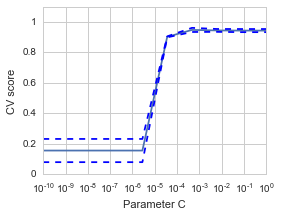

In [12]:
# Do the plotting
import matplotlib.pyplot as plt
plt.figure(1, figsize=(4, 3))
plt.clf()
plt.semilogx(C_s, scores)
plt.semilogx(C_s, np.array(scores) + np.array(scores_std), 'b--')
plt.semilogx(C_s, np.array(scores) - np.array(scores_std), 'b--')
locs, labels = plt.yticks()
plt.yticks(locs, list(map(lambda x: "%g" % x, locs)))
plt.ylabel('CV score')
plt.xlabel('Parameter C')
plt.ylim(0, 1.1)
plt.show()

In [22]:
diabetes = datasets.load_diabetes()
X = diabetes.data
y = diabetes.target

lasso = Lasso(random_state=0)
alphas = np.logspace(-4, -0.5, 30)

(0.0001, 0.31622776601683794)

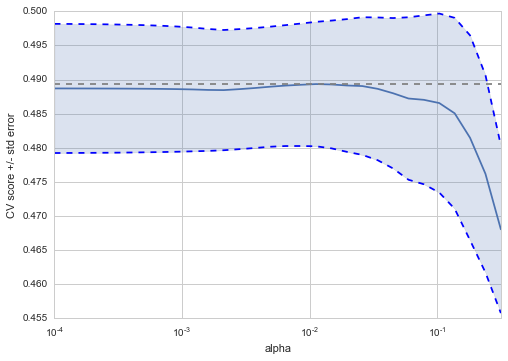

In [42]:
scores = []
scores_std = []

n_folds = 3

for alpha in alphas:
    lasso.alpha = alpha
    this_scores = cross_val_score(lasso, X, y, cv=n_folds, n_jobs=1)
    scores.append(np.mean(this_scores))
    scores_std.append(np.std(this_scores))

scores, scores_std = np.array(scores), np.array(scores_std)

plt.semilogx(alphas, scores)

# plot error lines showing +/- std. errors of the scores
std_error = scores_std / np.sqrt(n_folds)

plt.semilogx(alphas, scores + std_error, 'b--')
plt.semilogx(alphas, scores - std_error, 'b--')

# alpha=0.2 controls the translucency of the fill color
plt.fill_between(alphas, scores + std_error, scores - std_error, alpha=0.2)

plt.ylabel('CV score +/- std error')
plt.xlabel('alpha')
plt.axhline(np.max(scores), linestyle='--', color='.5')
plt.xlim([alphas[0], alphas[-1]])

In [41]:
# how much can you trust the selection of alpha?
# To answer this question we use the LassoCV object that sets its alpha
# parameter automatically from the data by internal cross-validation (i.e. it
# performs cross-validation on the training data it receives).
# We use external cross-validation to see how much the automatically obtained
# alphas differ across different cross-validation folds.
lasso_cv = LassoCV(alphas=alphas, random_state=0)
k_fold = KFold(3)

print("Answer to the bonus question:",
      "how much can you trust the selection of alpha?")
print()
print("Alpha parameters maximising the generalization score on different")
print("subsets of the data:")
for k, (train, test) in enumerate(k_fold.split(X, y)):
    lasso_cv.fit(X[train], y[train])
    print("[fold {0}] alpha: {1:.5f}, score: {2:.5f}".
          format(k, lasso_cv.alpha_, lasso_cv.score(X[test], y[test])))
print()
print("Answer: Not very much since we obtained different alphas for different")
print("subsets of the data and moreover, the scores for these alphas differ")
print("quite substantially.")

plt.show()

('Answer to the bonus question:', 'how much can you trust the selection of alpha?')
()
Alpha parameters maximising the generalization score on different
subsets of the data:
[fold 0] alpha: 0.07880, score: 0.45738
[fold 1] alpha: 0.01126, score: 0.49066
[fold 2] alpha: 0.04520, score: 0.50798
()
Answer: Not very much since we obtained different alphas for different
subsets of the data and moreover, the scores for these alphas differ
quite substantially.


Average difference of 0.007742 with std. dev. of 0.007688.


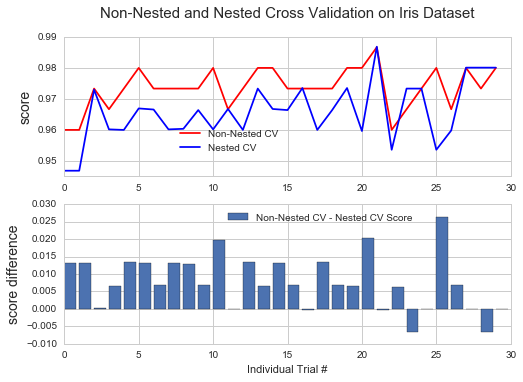

In [79]:
# Load the dataset
iris = datasets.load_iris()
X_iris = iris.data
y_iris = iris.target

# Set up possible values of parameters to optimize over
p_grid = {"C": [1, 10, 100],
          "gamma": [.01, .1]}

# We will use a Support Vector Classifier with "rbf" kernel
svc = svm.SVC(kernel="rbf")

# Number of random trials
NUM_TRIALS = 30

# Arrays to store scores
non_nested_scores = np.zeros(NUM_TRIALS)
nested_scores = np.zeros(NUM_TRIALS)

# Loop for each trial
for i in range(NUM_TRIALS):

    # Choose cross-validation techniques for the inner and outer loops,
    # independently of the dataset.
    # E.g "LabelKFold", "LeaveOneOut", "LeaveOneLabelOut", etc.
    inner_cv = KFold(n_splits=4, shuffle=True, random_state=i)
    outer_cv = KFold(n_splits=4, shuffle=True, random_state=i)

    # Non_nested parameter search and scoring
    clf = GridSearchCV(estimator=svc, param_grid=p_grid, cv=inner_cv)
    clf.fit(X_iris, y_iris)
    non_nested_scores[i] = clf.best_score_
    
#     print clf.best_params_
#     print clf.best_score_
#     print clf.cv_results_['split0_test_score'][clf.best_index_]
#     print clf.cv_results_['split1_test_score'][clf.best_index_]
#     print clf.cv_results_['split2_test_score'][clf.best_index_]
#     print clf.cv_results_['split3_test_score'][clf.best_index_]

    # Nested CV with parameter optimization
    nested_score = cross_val_score(clf, X=X_iris, y=y_iris, cv=outer_cv)
#     print nested_score
    nested_scores[i] = nested_score.mean()

score_difference = non_nested_scores - nested_scores

print("Average difference of {0:6f} with std. dev. of {1:6f}."
      .format(score_difference.mean(), score_difference.std()))

# Plot scores on each trial for nested and non-nested CV
plt.figure()
plt.subplot(211)
non_nested_scores_line, = plt.plot(non_nested_scores, color='r')
nested_line, = plt.plot(nested_scores, color='b')
plt.ylabel("score", fontsize="14")
plt.legend([non_nested_scores_line, nested_line],
           ["Non-Nested CV", "Nested CV"],
           bbox_to_anchor=(0, .4, .5, 0))
plt.title("Non-Nested and Nested Cross Validation on Iris Dataset",
          x=.5, y=1.1, fontsize="15")

# Plot bar chart of the difference.
plt.subplot(212)
difference_plot = plt.bar(range(NUM_TRIALS), score_difference)
plt.xlabel("Individual Trial #")
plt.legend([difference_plot],
           ["Non-Nested CV - Nested CV Score"],
           bbox_to_anchor=(0, 1, .8, 0))
plt.ylabel("score difference", fontsize="14")

plt.show()